In [1]:
import torch
import glob
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader,  TensorDataset, Dataset
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import math

from os import listdir
import shutil
import time
from tqdm import tqdm

#from torchvision import models, datasets, transforms
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

import imageio

import pickle

from google.colab import drive
drive.mount('/gdrive')

import random
random.seed(42)

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-0z78ydmv
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-0z78ydmv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# dataset creating 
class MyDataset(Dataset):
    
    def __init__(self, data, targets, transform=None):
        #self.data = data
        #self.targets = targets
        #self.data.sort()
        #self.targets.sort()
        #self.transform = transform

        self.dir_data = data
        self.dir_targets = targets

        self.list_data = listdir(data)
        self.list_targets = listdir(targets)

        self.list_data.sort()
        self.list_targets.sort()


        
    def __len__(self):
        #return len(self.targets)
        #return 9593
        if len(listdir(self.dir_data)) != len(listdir(self.dir_targets)):
            raise Exception(f'error {len(listdir(self.dir_data))} {len(listdir(self.dir_targets))}')
        return len(listdir(self.dir_data))

    def __getitem__(self, idx):
        #image = self.data[idx]
        #label = self.targets[idx]
        #if self.transform:
            #image = self.transform(image)
        #print(f'{self.dir_data}/{self.list_data[idx]}')
        with open(f'{self.dir_data}/{self.list_data[idx]}', 'rb') as f:
            image = pickle.load(f)

        with open(f'{self.dir_targets}/{self.list_targets[idx]}', 'rb') as f:
            label = pickle.load(f)

        return torch.from_numpy(image).float(), torch.from_numpy(label)

In [3]:
# dataset
#dir_img = 'gdrive/My Drive/Segmentation_project/train_val_images_cropped'
#dir_mask = 'gdrive/My Drive/Segmentation_project/train_val_masks_2cl_cropped'

#dataset = MyDataset(data=dir_img, targets=dir_mask)

In [4]:
# equal amount of images with total black and wb zones
#counter_black = []
#counter_wb = []
#for i in range(len(dataset)):
#    if sum(sum(sum(dataset[i][1]))) > 0:
#        counter_wb.append(i)
#    else:
#        counter_black.append(i)

#print(len(counter_black))
#print(len(counter_wb))



In [5]:
#with open('/gdrive/My Drive/Segmentation_project/counter_black', 'wb+') as f:
#    pickle.dump(counter_black, f)

#with open('/gdrive/My Drive/Segmentation_project/counter_wb', 'wb+') as f:
#    pickle.dump(counter_wb, f) 

In [6]:
#ind_wb = random.sample(counter_wb, 2600)
#ind_black = random.sample(counter_black, 2600)

#ind = ind_wb + ind_black
#print(len(ind))
#print(len(set(ind)))

In [7]:
#for index in tqdm(ind):
#    shutil.copy(f'/gdrive/My Drive/Segmentation_project/train_val_images_cropped/image_{index}', f'/gdrive/My Drive/Segmentation_project/train_val_images_cropped_balanced/image_{index}')
#    shutil.copy(f'/gdrive/My Drive/Segmentation_project/train_val_masks_2cl_cropped/mask_{index}', f'/gdrive/My Drive/Segmentation_project/train_val_masks_2cl_cropped_balanced/mask_{index}')

In [8]:
# dataset balanced
dir_img = '/gdrive/My Drive/Segmentation_project/train_val_images_cropped_balanced'
dir_mask = '/gdrive/My Drive/Segmentation_project/train_val_masks_2cl_cropped_balanced'

dataset_balanced = MyDataset(data=dir_img, targets=dir_mask)

#print(len(dataset_balanced))


train_dataset, val_dataset = torch.utils.data.random_split(dataset_balanced, [int(5200*0.8), int(5200*0.2)])
train_loader = DataLoader(train_dataset, batch_size = 52, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 52, shuffle = False)

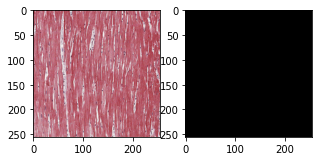

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(5,5))
axes[0].imshow(torch.transpose(torch.transpose(dataset_balanced[6][0], 0, 2), 0, 1))
axes[1].imshow(dataset_balanced[6][1].squeeze(), cmap = 'gray', vmin=0, vmax=1)

In [10]:
# IoU validation metrics
def validate_iou(model, val_loader, device):
    metrics = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        #print(labels.shape, 'labels')
        pred_mask = model(images).to(device)
        pred_mask = (pred_mask > 0.5).float()
        #print(pred_mask.shape, 'pred')
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), labels.long(), mode="binary")
        metrics.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").detach().cpu().numpy())
    
    #print(metrics)
    return np.array(metrics).mean()

In [11]:
# train function
def train(model, num_epochs=50):
    
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print('Using device:', device)
    
    device = torch.device("cuda")
    
    sum_acc = np.zeros((1,  num_epochs))
    sum_loss = sum_acc.copy()
    model.train()
    model.to(device)

    criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    best_accuracy = 0
    best_loss = 100

    for epoch in tqdm(range(num_epochs)):
        epoch_start = time.time()

        for img_batch, labels_batch in (train_loader):
            optimizer.zero_grad()
            #print(img_batch.shape)
            #print(labels_batch.shape, 'labels')
        
            output = model(img_batch.to(device))            
            #print(output.shape, 'output')

            #loss = criterion(output, labels_batch.to(device).unsqueeze(1))
            loss = criterion(output, labels_batch.to(device).unsqueeze(1))
            #print(loss, 'loss')
            loss.backward()
            optimizer.step()

        accuracy = validate_iou(model, val_loader, device)
        #print(accuracy)

        if best_accuracy < accuracy:
            best_accuracy = accuracy
            print('Best metrics')
            torch.save(model.state_dict(), '/gdrive/My Drive/Segmentation_project/weights/model_weights_efficientnet-b0_batch=52_100epochs.pth') #name of saved weights
        if best_loss > loss.cpu().item():
            best_loss = loss.cpu().item()
#             print('Best loss improved')

        sum_acc[0, epoch] = accuracy
        sum_loss[0, epoch] = loss  
        epoch_end = time.time()
        print("Epoch: {} Loss: {:.3f} IoU: {:.3f} Time: {:.4f}s".format(epoch, loss.item(), accuracy, epoch_end-epoch_start))
        
        #plt.plot(sum_acc[0,0:epoch].T)
        #plt.show()
    
    return sum_acc, sum_loss

In [ ]:
model = smp.Unet(encoder_name='efficientnet-b0', 
                 encoder_depth=5, 
                 encoder_weights='imagenet', 
                 decoder_use_batchnorm=True, 
                 decoder_channels=(256, 128, 64, 32, 16), 
                 decoder_attention_type=None, 
                 in_channels=3, 
                 classes=1, 
                 #activation='sigmoid', 
                 aux_params=None)

accuracy, loss = train(model, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Best metrics


  1%|          | 1/100 [30:09<49:46:23, 1809.93s/it]

Epoch: 0 Loss: 0.039 IoU: 0.851 Time: 1809.9332s


  2%|▏         | 2/100 [53:48<42:59:50, 1579.50s/it]

Epoch: 1 Loss: 0.055 IoU: 0.835 Time: 1418.1882s
Best metrics


  3%|▎         | 3/100 [1:17:36<40:41:49, 1510.40s/it]

Epoch: 2 Loss: 0.021 IoU: 0.863 Time: 1428.1727s


  4%|▍         | 4/100 [1:40:39<38:56:13, 1460.14s/it]

Epoch: 3 Loss: 0.096 IoU: 0.781 Time: 1383.0696s
Best metrics


  5%|▌         | 5/100 [2:03:48<37:51:26, 1434.60s/it]

Epoch: 4 Loss: 0.036 IoU: 0.878 Time: 1389.2981s


In [ ]:
np.save('/gdrive/My Drive/Segmentation_project/Loss_IoU/acc_1605_efficientnet-b0_batch=52_100epochs.npy', accuracy)
np.save('/gdrive/My Drive/Segmentation_project/Loss_IoU/loss_1605_efficientnet-b0_batch=52_100epochs.npy', loss)

In [ ]:
accuracy = np.load('/gdrive/My Drive/Segmentation_project/acc_0605_mobilenet_v2_batch=30.npy')
loss = np.load('/gdrive/My Drive/Segmentation_project/loss_0605_mobilenet_v2_batch=30.npy')

In [ ]:
epochs = np.linspace(1,100,100)

In [ ]:
import matplotlib
plt.figure(figsize=([10, 6]))
matplotlib.rcParams.update({'font.size': 16})
plt.title('batch_size = 60, encoder_name = efficientnet-b0', FontSize=20)
plt.plot(epochs, loss[0])
plt.xlabel('Epochs', FontSize=25)
plt.ylabel('Loss', FontSize=25)
plt.axis([0,20,0,1])

plt.savefig('/gdrive/My Drive/Segmentation_project/Loss_IoU/loss_0905_efficientnet-b0_batch=60_100epochs_act=sig.png')
plt.show()

In [ ]:
import matplotlib
plt.figure(figsize=([10, 5]))
matplotlib.rcParams.update({'font.size': 16})
plt.title('batch_size = 60, encoder_name = efficientnet-b0', FontSize=20)
plt.plot(epochs, accuracy[0])
plt.xlabel('Epochs', FontSize=25)
plt.ylabel('IoU', FontSize=25)
plt.axis([0,20,0,1])

plt.savefig('/gdrive/My Drive/Segmentation_project/Loss_IoU/acc_0905_efficientnet-b0_batch=60_100epochs_act=sig.png')
plt.show()

In [ ]:
# медианный фильтр, чтобы убрать полосы
# pretrained (ссылка) вместо ImageNet - посмотреть веса
# FPN / DeepLab


In [ ]:
# efficient/mobileNet
# аугментации (поворот, растяжение, цвет)
# дописать лит обзор про гистотрипсию и применение сетей +

In [ ]:
# Opencv медианный фильтр для картинок, чтобы убрать полосы
# дисбаланс классов, focalloss 
# загрузка с диска (взять tiff, нарезать)

In [ ]:
# equal amount of images with total black and wb zones
counter_black = []
counter_wb = []
for i in range(len(y_labels)):
    if sum(sum(y_labels[i][0])) > 0:
        counter_wb.append(i)
    else:
        counter_black.append(i)

print(len(counter_black))
print(len(counter_wb))

ind_wb = random.choices(counter_wb, weights=None, cum_weights=None, k=900)
ind_black = random.choices(counter_black, weights=None, cum_weights=None, k=900)

ind = ind_wb + ind_wb
print(len(ind))
x_images_sorted = x_images[ind]
del x_images
print(x_images_sorted.shape)
y_labels_sorted = y_labels[ind]
print(y_labels_sorted.shape)
del y_labels
